# Example: Tomographic Reconstruction with TensorFlow

In this example we show how a CNN can be used to reconstruct an image from a sinogram using self-supervised learning. 
The CNN takes the back projected image as an input and refines it so that it generates a sinogram (radon transform) that matches the original sinogram.

First we import all necessary modules

In [9]:
from nDTomo.sim.shapes.phantoms import SheppLogan
from nDTomo.utils.misc import showim
from nDTomo.ct.conv_tomo import fbpvol, sinocentering

from nDTomo.nn.models_tf import DCNN2D
from nDTomo.nn.utils_tf import tf_gpu_devices, ReduceLROnPlateau_custom
from nDTomo.nn.tomo_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_mask_circle
from nDTomo.nn.losses_tf import ssim_mae_loss

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf


Check if Tensorflow will run on GPU

In [10]:

tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 

print(physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Let's create a Shepp-Logan phantom

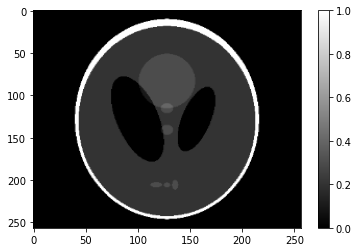

In [11]:
npix = 257
im = SheppLogan(npix)

showim(im, 1, cmap = 'gray')


Calculate the radon transform or sinogram

(1, 257, 257, 1)
(1, 257, 257, 1)


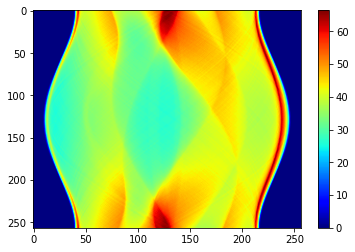

In [12]:
nproj = np.round(npix/1)
theta = tf_create_angles(nproj)

imtf = tf_tomo_transf(im)
print(imtf.shape)

sino = tf_tomo_radon(imtf, theta, interp_method='bilinear')
print(sino.shape)

showim(tf_tomo_squeeze(sino), 2)

Reconstruct using the filtered back projection algorithm

The dimensions of the reconstructed volume are  (257, 257)


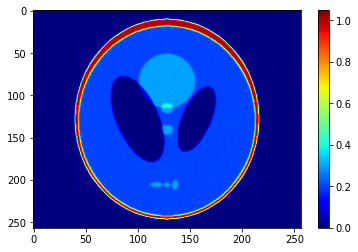

In [13]:
s = np.array(sino[0,:,:,0]).transpose()

fbp = fbpvol(s, theta=np.rad2deg(theta), nt = im.shape[0])
showim(fbp, 3, clim=(0, np.max(fbp)))

Let's create the back projected image; this image will be used as a starting point for the recontruction neural network

(1, 257, 257, 1)


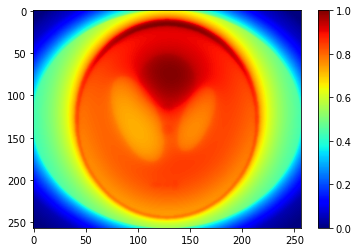

In [14]:
bptf = tf_tomo_bp(tf.cast(sino, tf.float32), theta)
bptf = bptf/tf.reduce_max(bptf)

print(bptf.shape)

showim(tf_tomo_squeeze(bptf), 3)

Let's create a 2D U-net CNN

In [15]:
model = DCNN2D(npix, nlayers=3, net='unet', dropout='No', batchnorm = 'No', 
                filtnums=64, nconvs=3, actlayerfi = 'linear', skipcon = 'No', dlayer = 'No')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 257, 257, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 257, 257, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 257, 257, 64  36928       ['conv2d_23[0][0]']              
                                )                                                           

Now we perform the training of the self-supervised CNN

In [16]:
epochs = 4001
save_interval = 100
lr_interval = 300

optimizer = tf.keras.optimizers.Adam(0.001)

reduce_rl_plateau = ReduceLROnPlateau_custom(patience=int(lr_interval/save_interval),
                                factor=0.5,
                                verbose=1, 
                                optim_lr=optimizer.learning_rate, 
                                reduce_lin=True)

loss = []

reduce_rl_plateau.on_train_begin()

kk = 1
for epoch in tqdm(range(epochs)):

    start = time.time()
    
    with tf.GradientTape(persistent=True) as tape:
        
        generated_img = model(bptf)
        
        generated_img = tf.abs(generated_img)
        
        gen_sino = tf_tomo_radon(generated_img, theta, tile=True)

        nnet_loss = ssim_mae_loss(tf.cast(sino, tf.float32), gen_sino)
                
    grad_nnet = tape.gradient(nnet_loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grad_nnet, model.trainable_variables))    
    
    loss.append(nnet_loss)

    if epoch % save_interval == 0 and epoch != 0:
            
        print('Time for epoch {} to {} is {} sec/it - gen_loss = {}'.format(epoch - save_interval + 1, epoch, time.time() - start, nnet_loss))

        reduce_rl_plateau.on_epoch_end(kk, nnet_loss)
    
        kk = kk + 1



  3%|▎         | 103/4001 [00:08<05:02, 12.91it/s]

Time for epoch 1 to 100 is 0.07649970054626465 sec/it - gen_loss = 1.7744929790496826


  5%|▌         | 203/4001 [00:15<04:55, 12.83it/s]

Time for epoch 101 to 200 is 0.07405328750610352 sec/it - gen_loss = 1.391629934310913


  8%|▊         | 303/4001 [00:23<04:47, 12.87it/s]

Time for epoch 201 to 300 is 0.07599902153015137 sec/it - gen_loss = 1.2280464172363281


 10%|█         | 403/4001 [00:31<04:38, 12.91it/s]

Time for epoch 301 to 400 is 0.07400012016296387 sec/it - gen_loss = 1.096798062324524


 13%|█▎        | 503/4001 [00:39<04:29, 12.97it/s]

Time for epoch 401 to 500 is 0.07650136947631836 sec/it - gen_loss = 0.6700987815856934


 15%|█▌        | 603/4001 [00:46<04:27, 12.70it/s]

Time for epoch 501 to 600 is 0.07699966430664062 sec/it - gen_loss = 0.8800399899482727


 18%|█▊        | 703/4001 [00:54<04:12, 13.05it/s]

Time for epoch 601 to 700 is 0.07500028610229492 sec/it - gen_loss = 0.4209963083267212


 20%|██        | 803/4001 [01:02<04:11, 12.70it/s]

Time for epoch 701 to 800 is 0.0775001049041748 sec/it - gen_loss = 0.3845409154891968


 23%|██▎       | 903/4001 [01:10<04:06, 12.56it/s]

Time for epoch 801 to 900 is 0.07700181007385254 sec/it - gen_loss = 0.40176868438720703


 25%|██▌       | 1003/4001 [01:18<03:52, 12.90it/s]

Time for epoch 901 to 1000 is 0.07450008392333984 sec/it - gen_loss = 0.6286866068840027


 28%|██▊       | 1103/4001 [01:25<03:48, 12.66it/s]

Time for epoch 1001 to 1100 is 0.07845711708068848 sec/it - gen_loss = 0.38346076011657715


 30%|███       | 1203/4001 [01:33<03:34, 13.06it/s]

Time for epoch 1101 to 1200 is 0.07349920272827148 sec/it - gen_loss = 0.42660149931907654


 33%|███▎      | 1303/4001 [01:41<03:26, 13.04it/s]

Time for epoch 1201 to 1300 is 0.07849907875061035 sec/it - gen_loss = 0.3259650468826294


 35%|███▌      | 1403/4001 [01:49<03:24, 12.68it/s]

Time for epoch 1301 to 1400 is 0.07799911499023438 sec/it - gen_loss = 0.2645626962184906


 38%|███▊      | 1503/4001 [01:57<03:14, 12.82it/s]

Time for epoch 1401 to 1500 is 0.07599782943725586 sec/it - gen_loss = 0.2771398723125458


 40%|████      | 1603/4001 [02:04<03:05, 12.94it/s]

Time for epoch 1501 to 1600 is 0.07599949836730957 sec/it - gen_loss = 0.29408448934555054


 43%|████▎     | 1703/4001 [02:12<03:00, 12.75it/s]

Time for epoch 1601 to 1700 is 0.07799959182739258 sec/it - gen_loss = 0.19642561674118042


 45%|████▌     | 1803/4001 [02:20<02:50, 12.88it/s]

Time for epoch 1701 to 1800 is 0.07643556594848633 sec/it - gen_loss = 0.371931791305542


 48%|████▊     | 1903/4001 [02:28<02:42, 12.95it/s]

Time for epoch 1801 to 1900 is 0.07599830627441406 sec/it - gen_loss = 0.22092169523239136


 50%|█████     | 2003/4001 [02:35<02:34, 12.92it/s]

Time for epoch 1901 to 2000 is 0.0755000114440918 sec/it - gen_loss = 0.2730441689491272

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


 53%|█████▎    | 2103/4001 [02:43<02:27, 12.85it/s]

Time for epoch 2001 to 2100 is 0.07400035858154297 sec/it - gen_loss = 0.2007094919681549


 55%|█████▌    | 2203/4001 [02:51<02:20, 12.78it/s]

Time for epoch 2101 to 2200 is 0.07749581336975098 sec/it - gen_loss = 0.1718185693025589


 58%|█████▊    | 2303/4001 [02:59<02:12, 12.84it/s]

Time for epoch 2201 to 2300 is 0.0735013484954834 sec/it - gen_loss = 0.19389772415161133


 60%|██████    | 2403/4001 [03:06<02:03, 12.98it/s]

Time for epoch 2301 to 2400 is 0.07537412643432617 sec/it - gen_loss = 0.15667793154716492


 63%|██████▎   | 2503/4001 [03:14<01:56, 12.82it/s]

Time for epoch 2401 to 2500 is 0.07649922370910645 sec/it - gen_loss = 0.15782147645950317


 65%|██████▌   | 2603/4001 [03:22<01:49, 12.72it/s]

Time for epoch 2501 to 2600 is 0.07949972152709961 sec/it - gen_loss = 0.16307604312896729


 68%|██████▊   | 2703/4001 [03:30<01:39, 12.99it/s]

Time for epoch 2601 to 2700 is 0.07699990272521973 sec/it - gen_loss = 0.3098191022872925

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


 70%|███████   | 2803/4001 [03:37<01:32, 13.01it/s]

Time for epoch 2701 to 2800 is 0.07449769973754883 sec/it - gen_loss = 0.14002054929733276


 73%|███████▎  | 2903/4001 [03:45<01:24, 12.99it/s]

Time for epoch 2801 to 2900 is 0.07806015014648438 sec/it - gen_loss = 0.1920466125011444


 75%|███████▌  | 3003/4001 [03:53<01:18, 12.69it/s]

Time for epoch 2901 to 3000 is 0.08050084114074707 sec/it - gen_loss = 0.17412829399108887


 78%|███████▊  | 3103/4001 [04:01<01:10, 12.73it/s]

Time for epoch 3001 to 3100 is 0.07487726211547852 sec/it - gen_loss = 0.156910702586174

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


 80%|████████  | 3203/4001 [04:09<01:02, 12.77it/s]

Time for epoch 3101 to 3200 is 0.0755002498626709 sec/it - gen_loss = 0.1448795199394226


 83%|████████▎ | 3303/4001 [04:16<00:53, 13.04it/s]

Time for epoch 3201 to 3300 is 0.07650089263916016 sec/it - gen_loss = 0.14734849333763123


 85%|████████▌ | 3403/4001 [04:24<00:47, 12.68it/s]

Time for epoch 3301 to 3400 is 0.0775001049041748 sec/it - gen_loss = 0.102899469435215


 88%|████████▊ | 3503/4001 [04:32<00:38, 12.89it/s]

Time for epoch 3401 to 3500 is 0.07700157165527344 sec/it - gen_loss = 0.13999275863170624


 90%|█████████ | 3603/4001 [04:40<00:30, 13.19it/s]

Time for epoch 3501 to 3600 is 0.07549810409545898 sec/it - gen_loss = 0.13614386320114136


 93%|█████████▎| 3703/4001 [04:48<00:23, 12.90it/s]

Time for epoch 3601 to 3700 is 0.07800006866455078 sec/it - gen_loss = 0.14243756234645844

Epoch 00038: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


 95%|█████████▌| 3803/4001 [04:55<00:15, 12.96it/s]

Time for epoch 3701 to 3800 is 0.07899737358093262 sec/it - gen_loss = 0.1293221116065979


 98%|█████████▊| 3903/4001 [05:03<00:07, 12.78it/s]

Time for epoch 3801 to 3900 is 0.0794992446899414 sec/it - gen_loss = 0.13444064557552338


100%|██████████| 4001/4001 [05:11<00:00, 12.86it/s]

Time for epoch 3901 to 4000 is 0.07449984550476074 sec/it - gen_loss = 0.12815852463245392

Epoch 00041: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


Let's create now the CNN reconstructed image and compare it with the FBP algorithm

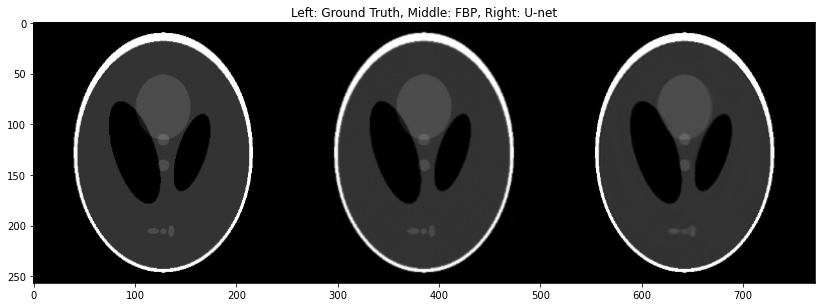

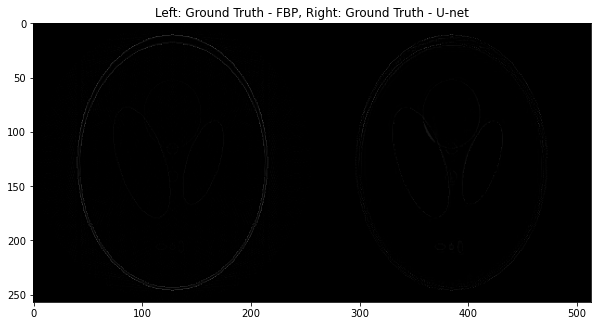

In [19]:
generated_img = model(bptf)
generated_img = tf.abs(generated_img)
generated_img = tf_mask_circle(generated_img, npix=0)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((im, fbp, generated_img[0,:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: U-net')
plt.show()

plt.figure(2, figsize=(10,10));plt.clf()
plt.imshow(np.concatenate((im - fbp, im - generated_img[0,:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth - FBP, Right: Ground Truth - U-net')
plt.show()

Let's calculate some metrics to compare the FBP and CNN reconstructions

In [20]:
imtf = np.reshape(im, (1, im.shape[0], im.shape[1],1))
imfbp = np.reshape(fbp, (1, fbp.shape[0], fbp.shape[1],1))

maeFBP = tf.reduce_mean(tf.keras.losses.MAE(im, fbp)).numpy()
maeCNN = tf.reduce_mean(tf.keras.losses.MAE(im, generated_img[0,:,:,0])).numpy()

mseFBP = tf.reduce_mean(tf.keras.losses.MSE(im, fbp)).numpy()
mseCNN = tf.reduce_mean(tf.keras.losses.MSE(im, generated_img[0,:,:,0])).numpy()

psnrFBP = tf.image.psnr(imtf, imfbp, 1).numpy()
psnrCNN = tf.image.psnr(imtf, generated_img, 1).numpy()

ssimFBP = tf.image.ssim(imtf, imfbp, 1).numpy()
ssimCNN = tf.image.ssim(imtf, np.array(generated_img, dtype='float64'), 1).numpy()

print(maeFBP, maeCNN)
print(mseFBP, mseCNN)
print(psnrFBP, psnrCNN)
print(ssimFBP, ssimCNN)


0.009661197566735464 0.004310307
0.0007830300505307404 0.00019400737
[31.062214] [37.121815]
[0.95534176] [0.9859173]
